In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_runner
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dataclasses
import pandas as pd
import statsmodels.api as sm
import ISLP
import ISLP.models
import subprocess
import io

MainProcess


In [2]:
# Prepare datasets
fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated/', fls.result_dir + '/many_abbr_res/')

In [3]:
# Read results from vast.ai
files = glob.glob(fls.result_dir + '/many_abbr_res/' + '*.pickle')
dicts = []
dicts_kaggle_comp = []
for f in files:    
    print(f)
    data = fls.dill_load(f)    
    d = data.modifier_values
    d['label'] = data.label
    d['git_commit_id'] = data.git_commit_id
    d['use_missing_value'] = data.use_missing_value
    d['cv_score'] = fls.score_competition_metric(data.inferred_test_data, data.test_data)

    d_kaggle_comp = dict()
    d_kaggle_comp['label'] = data.label
    d_kaggle_comp['git_commit_id'] = d['git_commit_id']
    d_kaggle_comp['use_missing_value'] = d['use_missing_value']
    d_kaggle_comp['seed'] = d['seed']   
    d_kaggle_comp['cv_score'] = d['cv_score']

    dicts_kaggle_comp.append(d_kaggle_comp)

    # First set
    #if not (d['seed']<26 or d['use_missing_value']): print('skip'); continue

    # New
    if not (d['seed']>=26 or d['use_missing_value']): print('skip'); continue
    
    for partial in fls.DataSelector().datasets:
        data_selector = fls.DataSelector()
        data_selector.datasets = [partial]
        d['cv_score_' + partial] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))
    d['k_score']= np.nan

    dicts.append(d)    
p = pd.DataFrame(dicts)
p.sort_values(['seed', 'git_commit_id'], inplace=True);

p_kaggle_comp = pd.DataFrame(dicts_kaggle_comp)
p_kaggle_comp.sort_values(['seed', 'git_commit_id'], inplace=True);

# First set
# p = p[np.logical_or(p['seed']<26, p['use_missing_value'])]

# New
#p = p[np.logical_or(p['seed']>=26, p['use_missing_value'])]

p = p.reset_index()
p_kaggle_comp = p_kaggle_comp.reset_index()

d:/flagellar/results//many_abbr_res\Baseline_0M_f766ff07_547 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_0_a103863a_651 _a.pickle
skip
d:/flagellar/results//many_abbr_res\Baseline_10_a103863a_245 _a.pickle
skip
d:/flagellar/results//many_abbr_res\Baseline_11_a103863a_089 _a.pickle
skip
d:/flagellar/results//many_abbr_res\Baseline_12_ed604774_284 _a.pickle
skip
d:/flagellar/results//many_abbr_res\Baseline_13_f766ff07_795 _a.pickle
skip
d:/flagellar/results//many_abbr_res\Baseline_14_f766ff07_275 _a.pickle
skip
d:/flagellar/results//many_abbr_res\Baseline_15_f766ff07_207 _a.pickle
skip
d:/flagellar/results//many_abbr_res\Baseline_16_f766ff07_300 _a.pickle
skip
d:/flagellar/results//many_abbr_res\Baseline_17_f766ff07_057 _a.pickle
skip
d:/flagellar/results//many_abbr_res\Baseline_18_f766ff07_2 _a.pickle
skip
d:/flagellar/results//many_abbr_res\Baseline_19_f766ff07_352 _a.pickle
skip
d:/flagellar/results//many_abbr_res\Baseline_1_a103863a_357 _a.pickle
skip
d:/flagellar/results/

In [4]:
# Load Kaggle results
p_kaggle_results = pd.read_csv(fls.code_dir + '../kaggle_results.csv').reset_index()

In [5]:
# Add competition results
csv = subprocess.run('kaggle competitions submissions -q -csv -c byu-locating-bacterial-flagellar-motors-2025', encoding = 'utf-8', shell=True, stdout=subprocess.PIPE)
lines = csv.stdout.split('\n')[1:]
data_str = "\n".join(lines)
p_submissions = pd.read_fwf(io.StringIO(data_str), skiprows=[1])
for i_i in range(len(p_kaggle_results)):
    mv_str = 'Ma' if p_kaggle_results.loc[i_i, 'use_missing_value'] else ''
    name_str = p_kaggle_results.loc[i_i, 'label'] + '_' + str(p_kaggle_results.loc[i_i, 'seed']) + mv_str + '_' + p_kaggle_results.loc[i_i, 'git_commit_id'][:8]
    for i_k in range(len(p_submissions)):
        if name_str == p_submissions.loc[i_k, 'description']:
            score = p_submissions.loc[i_k, 'publicScore']
            if not np.isnan(score):
                if np.isnan(p_kaggle_results.loc[i_i, 'k_score']):
                    p_kaggle_results.loc[i_i, 'k_score'] = score
                    print(f'Added score of {score:1.3} for {name_str}')
                else:
                    if not score == p_kaggle_results.loc[i_i, 'k_score']:
                        raise Exception(f'Mismatch for {name_str}: {score:1.3} vs {p_kaggle_results.loc[i_i, "k_score"]:1.3}')
            else:
                print('NaN score found for ', name_str)            
            break

Added score of 0.525 for Baseline_31_e7473985
Added score of 0.595 for Baseline_32_e7473985
Added score of 0.179 for Baseline_33_e7473985
Added score of 0.216 for Baseline_34_e7473985
Added score of 0.012 for Baseline_35_e7473985


In [6]:

#print(p_kaggle_results)
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p_kaggle_comp)):
        if p_kaggle_results['seed'][i_k] == p_kaggle_comp['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p_kaggle_comp['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p_kaggle_comp['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p_kaggle_comp['label'][i_i]:
            p_kaggle_comp.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p)):
        if p_kaggle_results['seed'][i_k] == p['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p['label'][i_i]:
            p.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]

In [7]:
# Write results to Kaggle results file
p_kaggle_cache = copy.deepcopy(p_kaggle_comp[['label', 'git_commit_id', 'use_missing_value', 'seed', 'cv_score', 'k_score']])
p_kaggle_cache.to_csv(fls.code_dir + '../kaggle_results.csv')

In [8]:
p.to_csv(fls.code_dir + '../results.csv')
p

,index,seed,scale_percentile_value,img_size,n_epochs,model_name,use_pretrained_weights,box_size,trust,fix_norm_bug,...,ycw,label,git_commit_id,use_missing_value,cv_score,cv_score_tom,cv_score_ycw,cv_score_aba,cv_score_mba,k_score
0,0,0,2.000000,640,30,yolov8m,True,24,4,False,...,False,Baseline,f766ff07dc1f14622ab82ab5f9acdf38affabf58,True,0.547101,0.915698,0.698925,0.548961,0.313531,0.648
1,1,26,2.966396,768,27,yolov8m,True,20,4,True,...,True,Baseline,e747398584115f4ffbdcd7d82118f284646eb463,False,0.341782,0.885093,0.061728,0.000000,0.258765,0.432
2,2,27,3.790945,640,29,yolo11m,True,20,3,True,...,False,Baseline,e747398584115f4ffbdcd7d82118f284646eb463,False,0.509761,0.847458,0.698925,0.639535,0.202703,0.676
3,3,28,4.407336,640,46,yolo11m,False,26,1,False,...,False,Baseline,e747398584115f4ffbdcd7d82118f284646eb463,False,0.354421,0.752351,0.121951,0.065789,0.321252,0.384
4,4,29,1.200188,768,35,yolov8m,True,24,3,False,...,False,Baseline,e747398584115f4ffbdcd7d82118f284646eb463,False,0.554348,0.872781,0.652174,0.575221,0.351882,0.657
5,5,30,1.943195,832,32,yolov8m,True,20,2,True,...,False,Baseline,e747398584115f4ffbdcd7d82118f284646eb463,False,0.363428,0.900621,0.121951,0.016611,0.282392,0.532
6,6,31,4.612687,704,22,yolo11m,True,25,2,False,...,False,Baseline,e747398584115f4ffbdcd7d82118f284646eb463,False,0.530747,0.888554,0.604396,0.398773,0.397083,0.525
7,7,32,1.640971,896,37,yolov8m,True,23,4,True,...,True,Baseline,e747398584115f4ffbdcd7d82118f284646eb463,False,0.521292,0.891239,0.698925,0.481928,0.313531,0.595
8,8,33,2.774569,704,37,yolo11m,True,27,3,False,...,True,Baseline,e747398584115f4ffbdcd7d82118f284646eb463,False,0.515196,0.419580,0.604396,0.297806,0.650842,0.179
9,9,34,1.016113,576,46,yolov8m,True,21,1,True,...,False,Baseline,e747398584115f4ffbdcd7d82118f284646eb463,False,0.337423,0.786164,0.238095,0.176849,0.194585,0.216


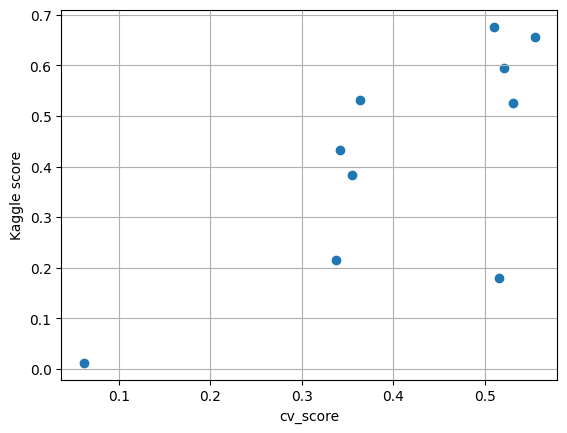

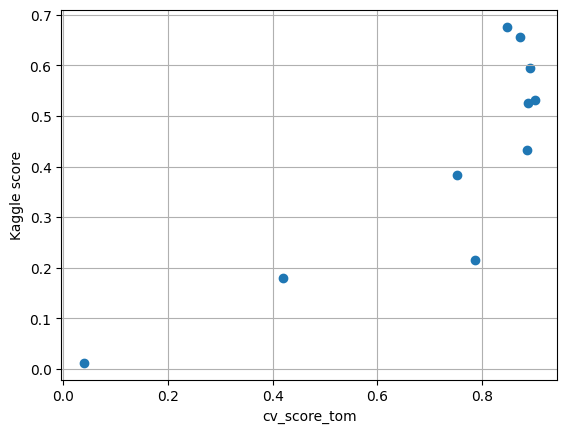

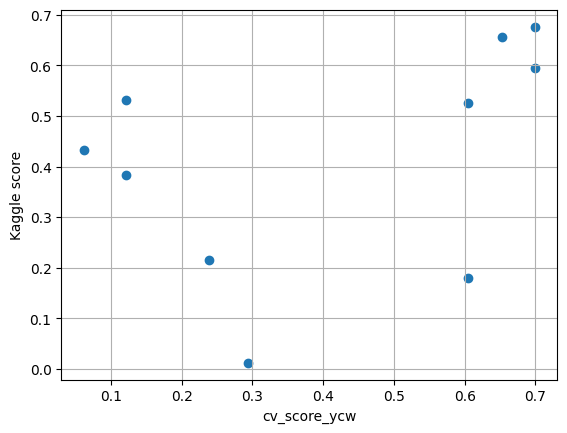

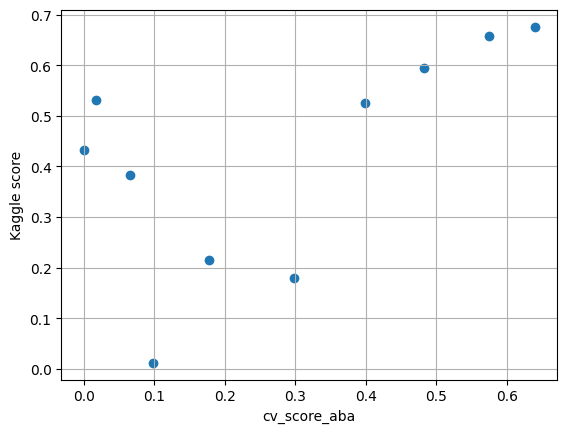

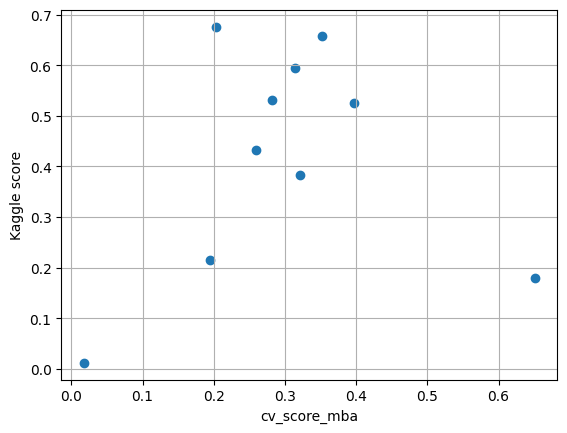

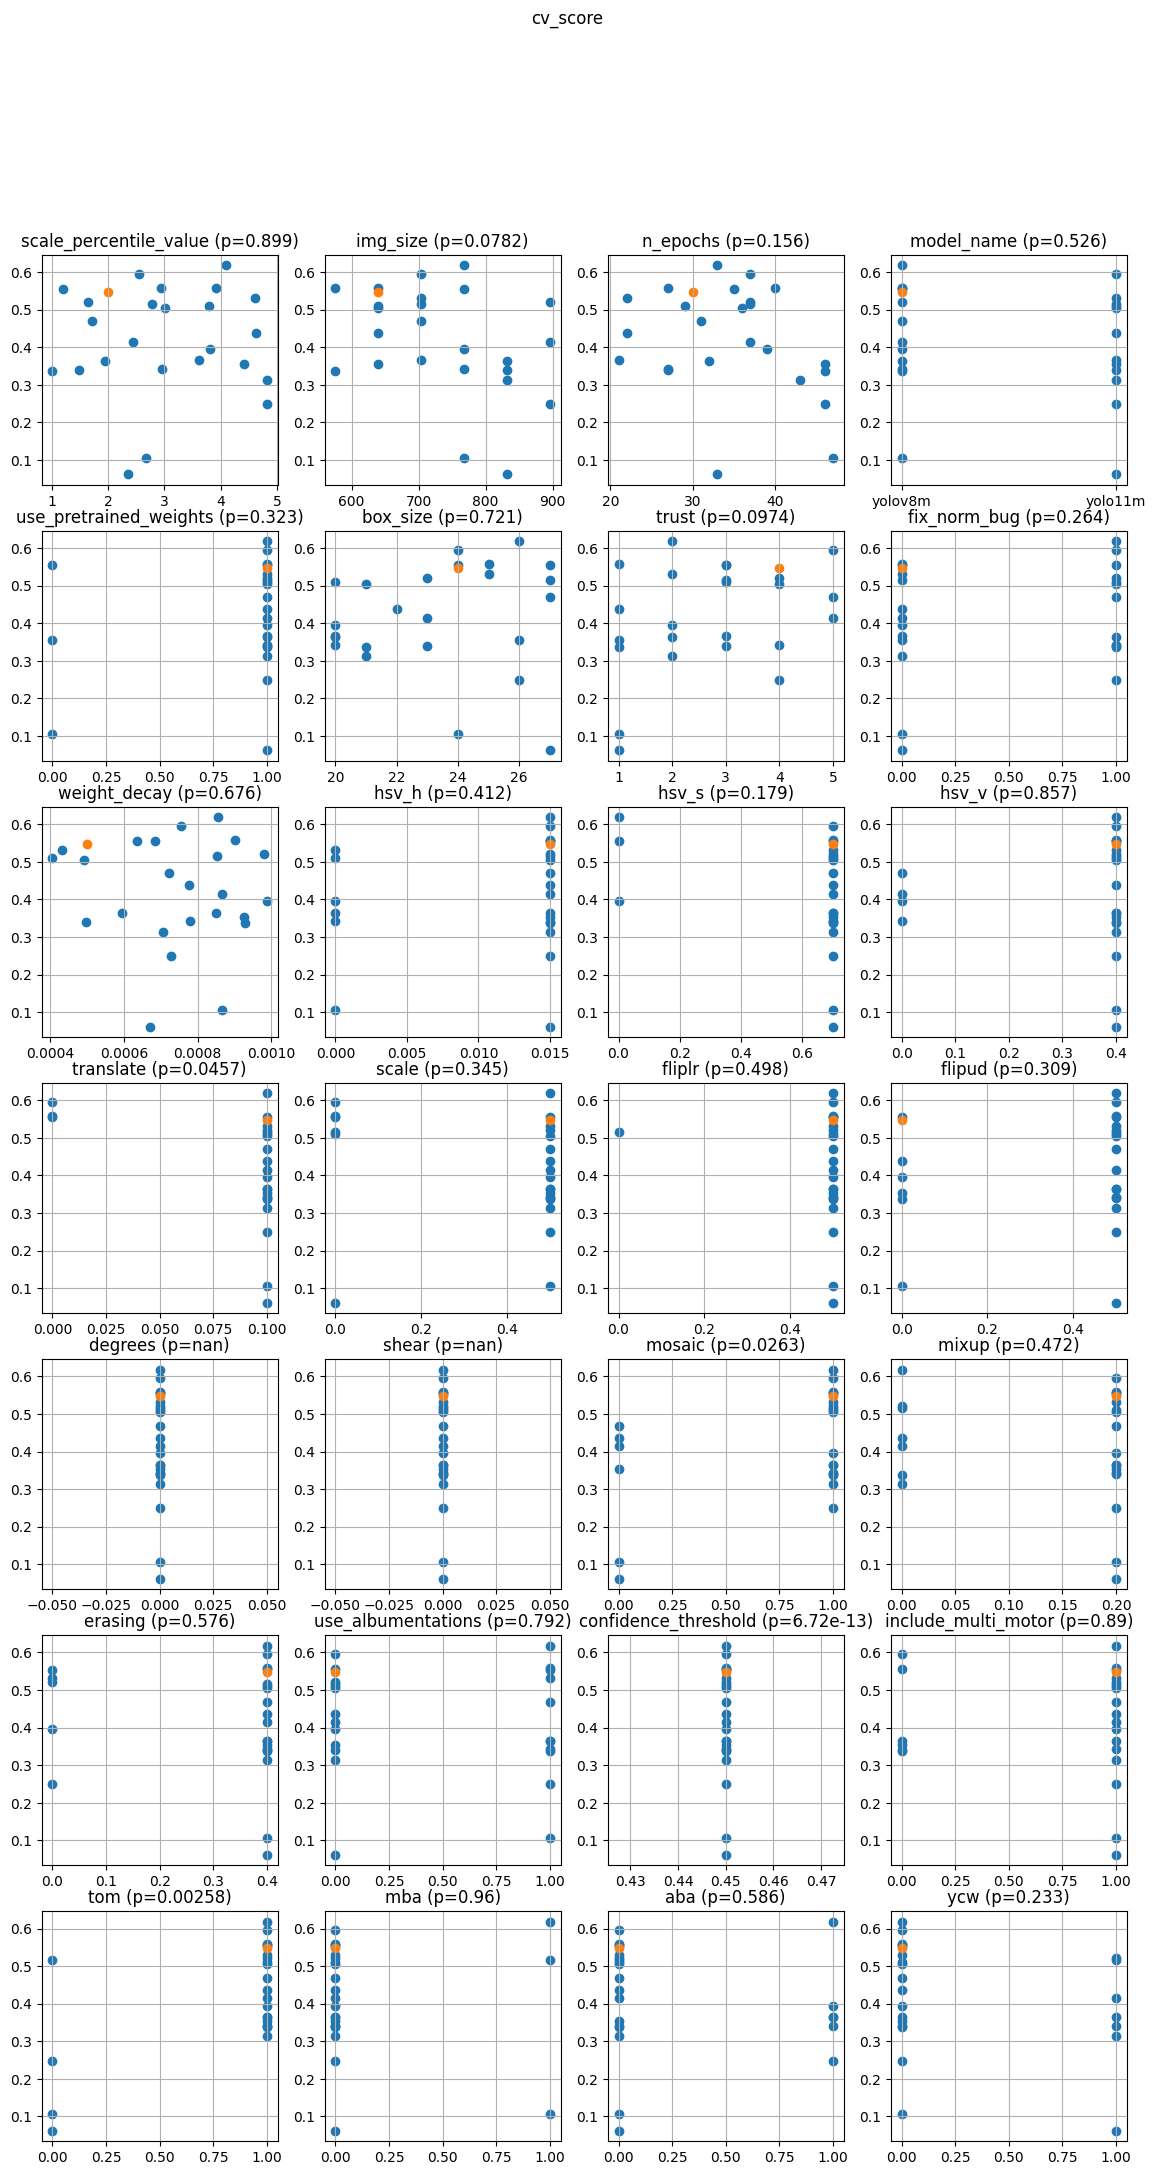

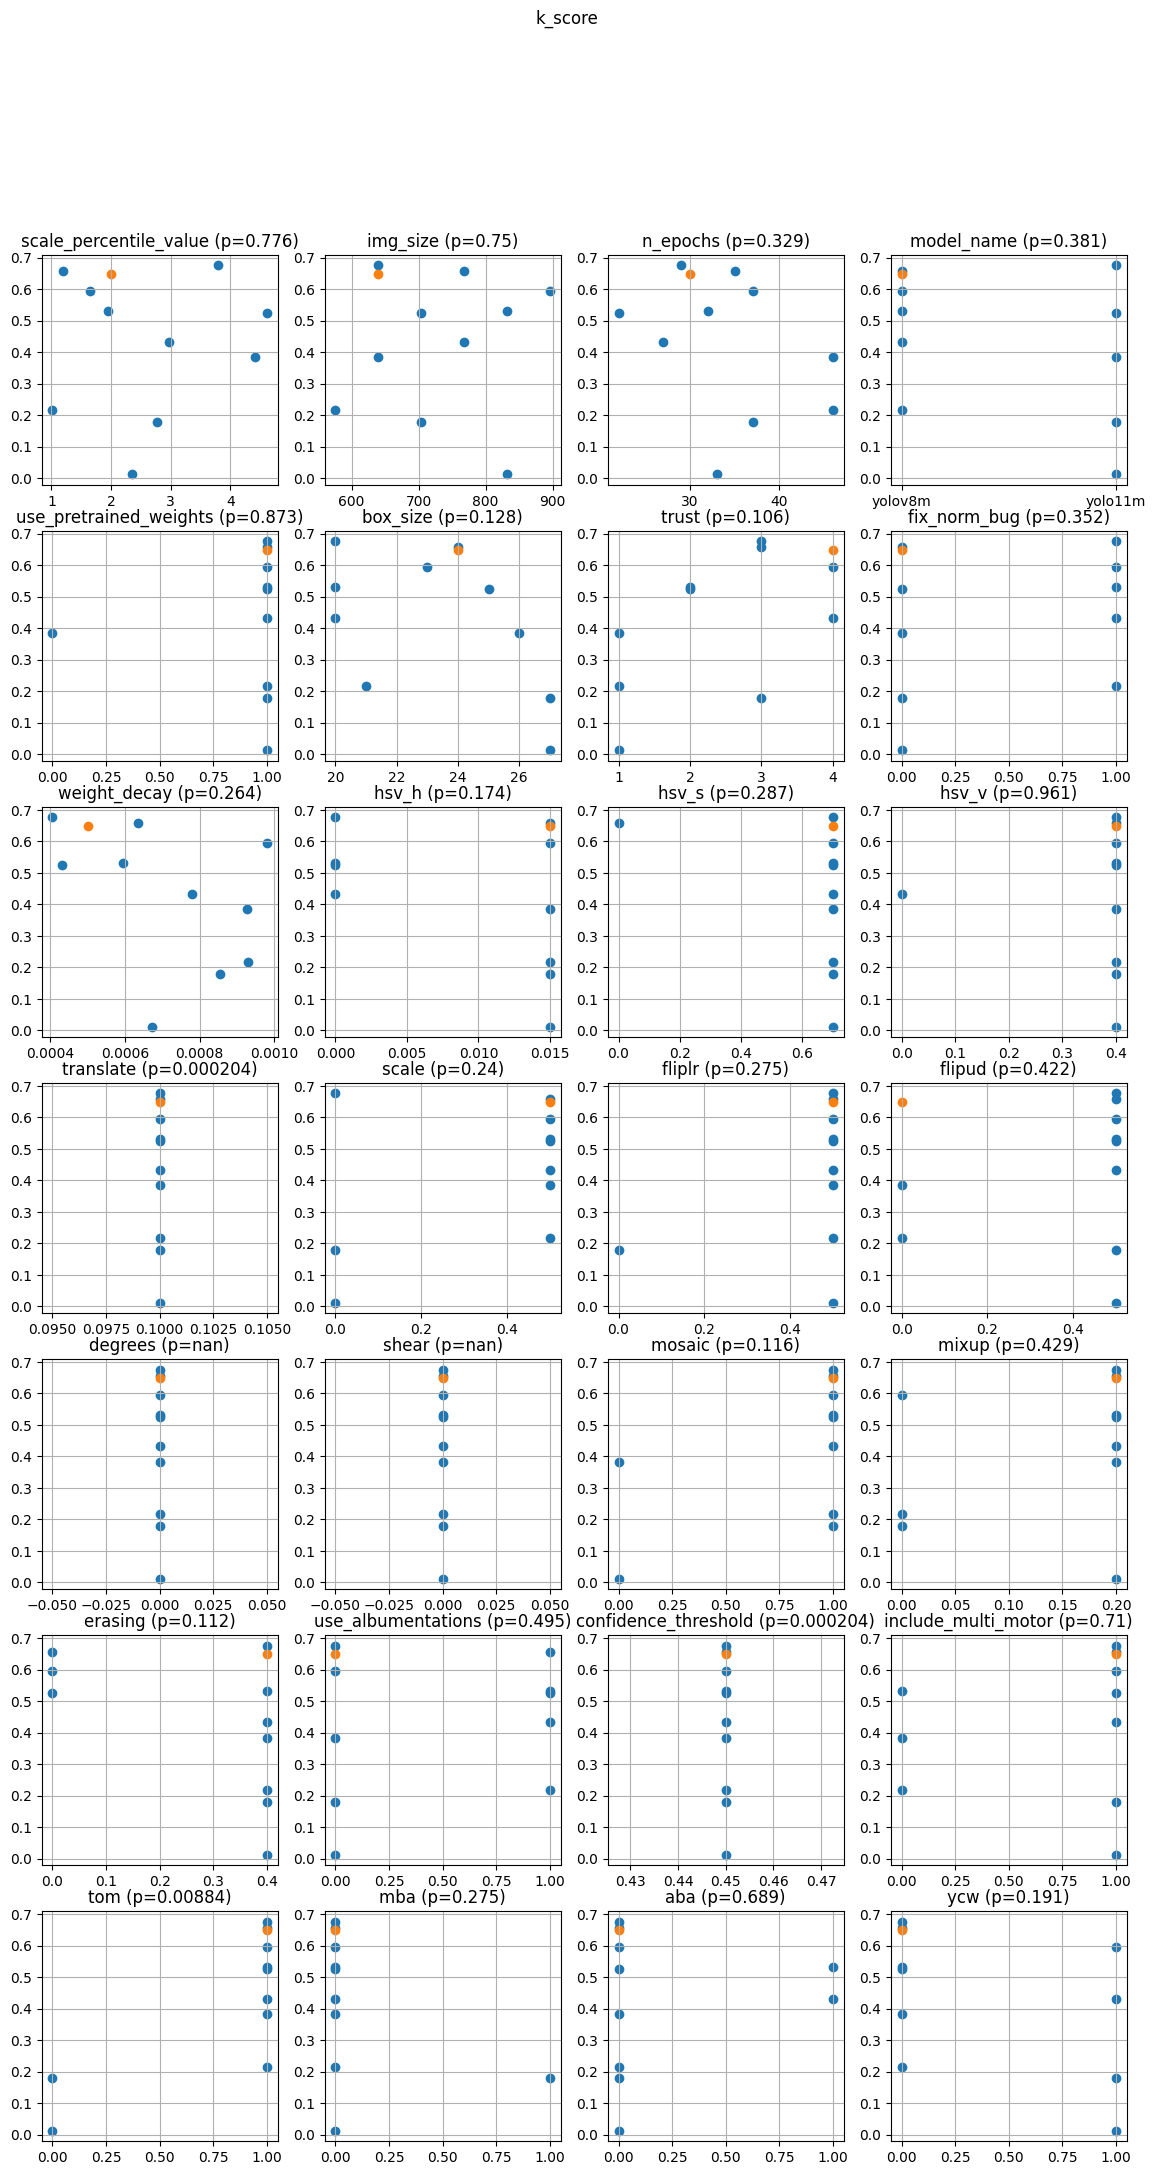

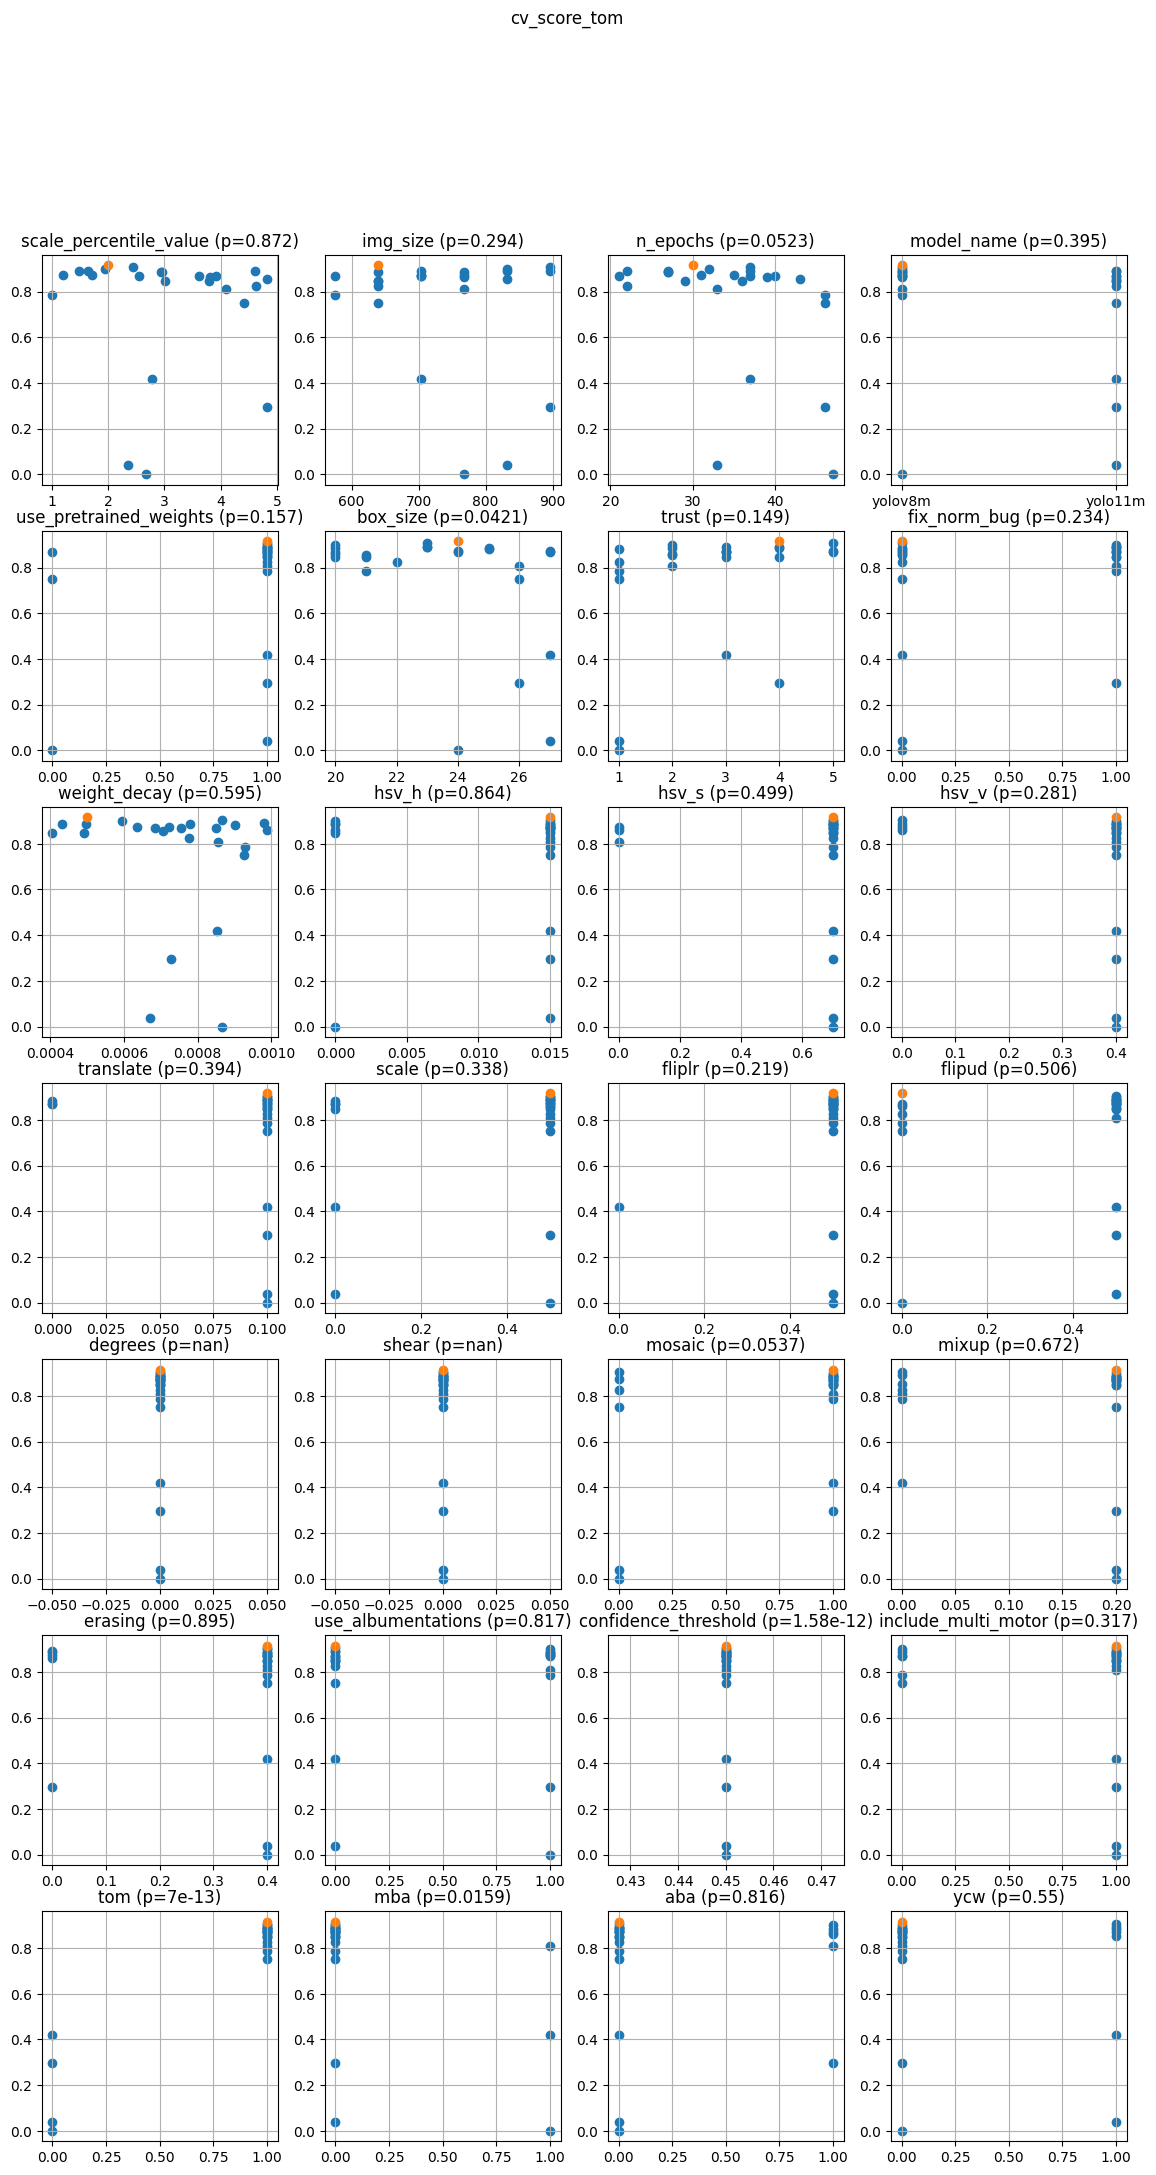

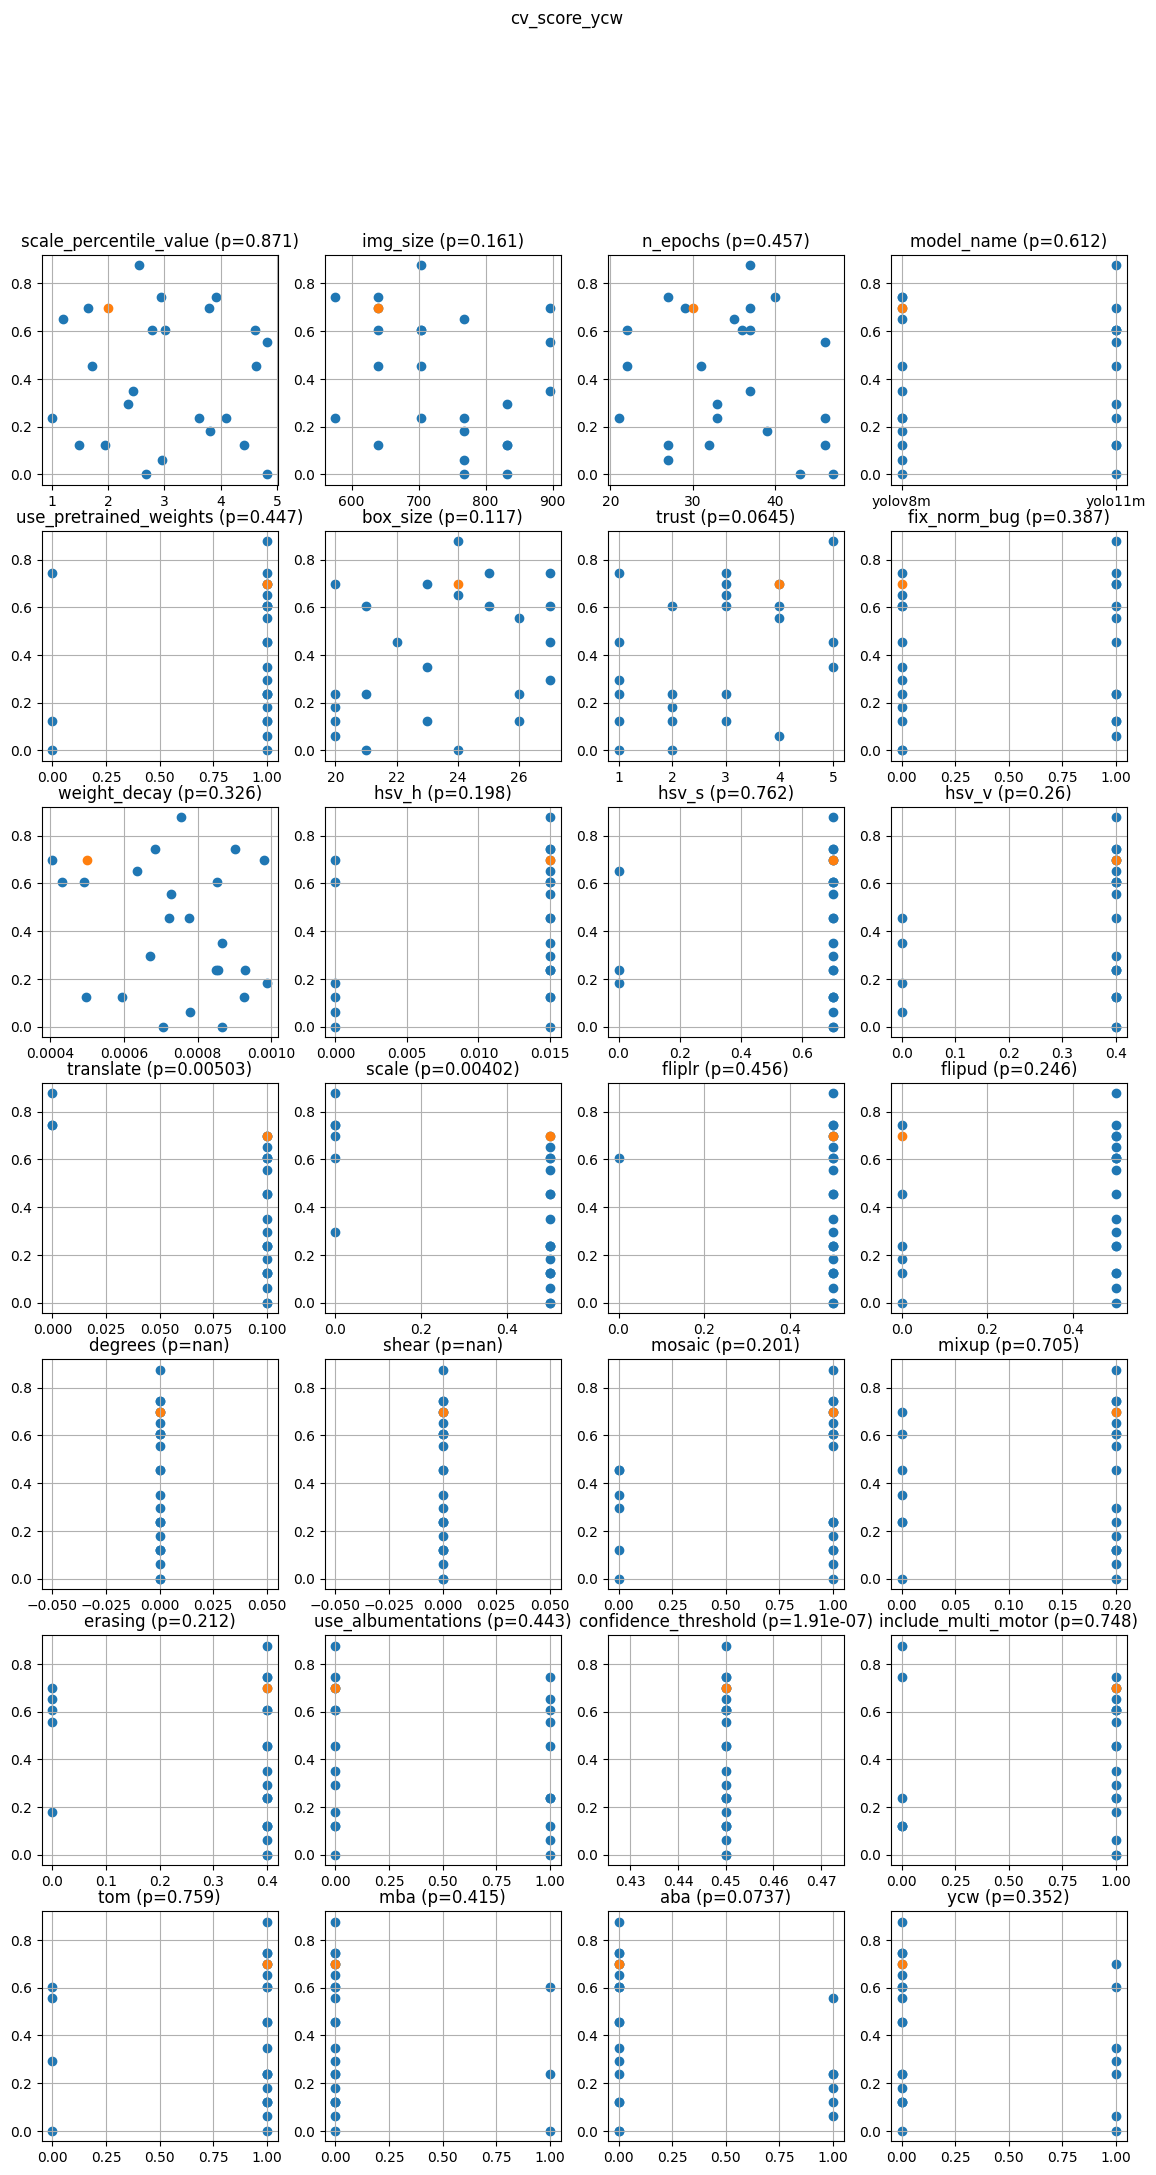

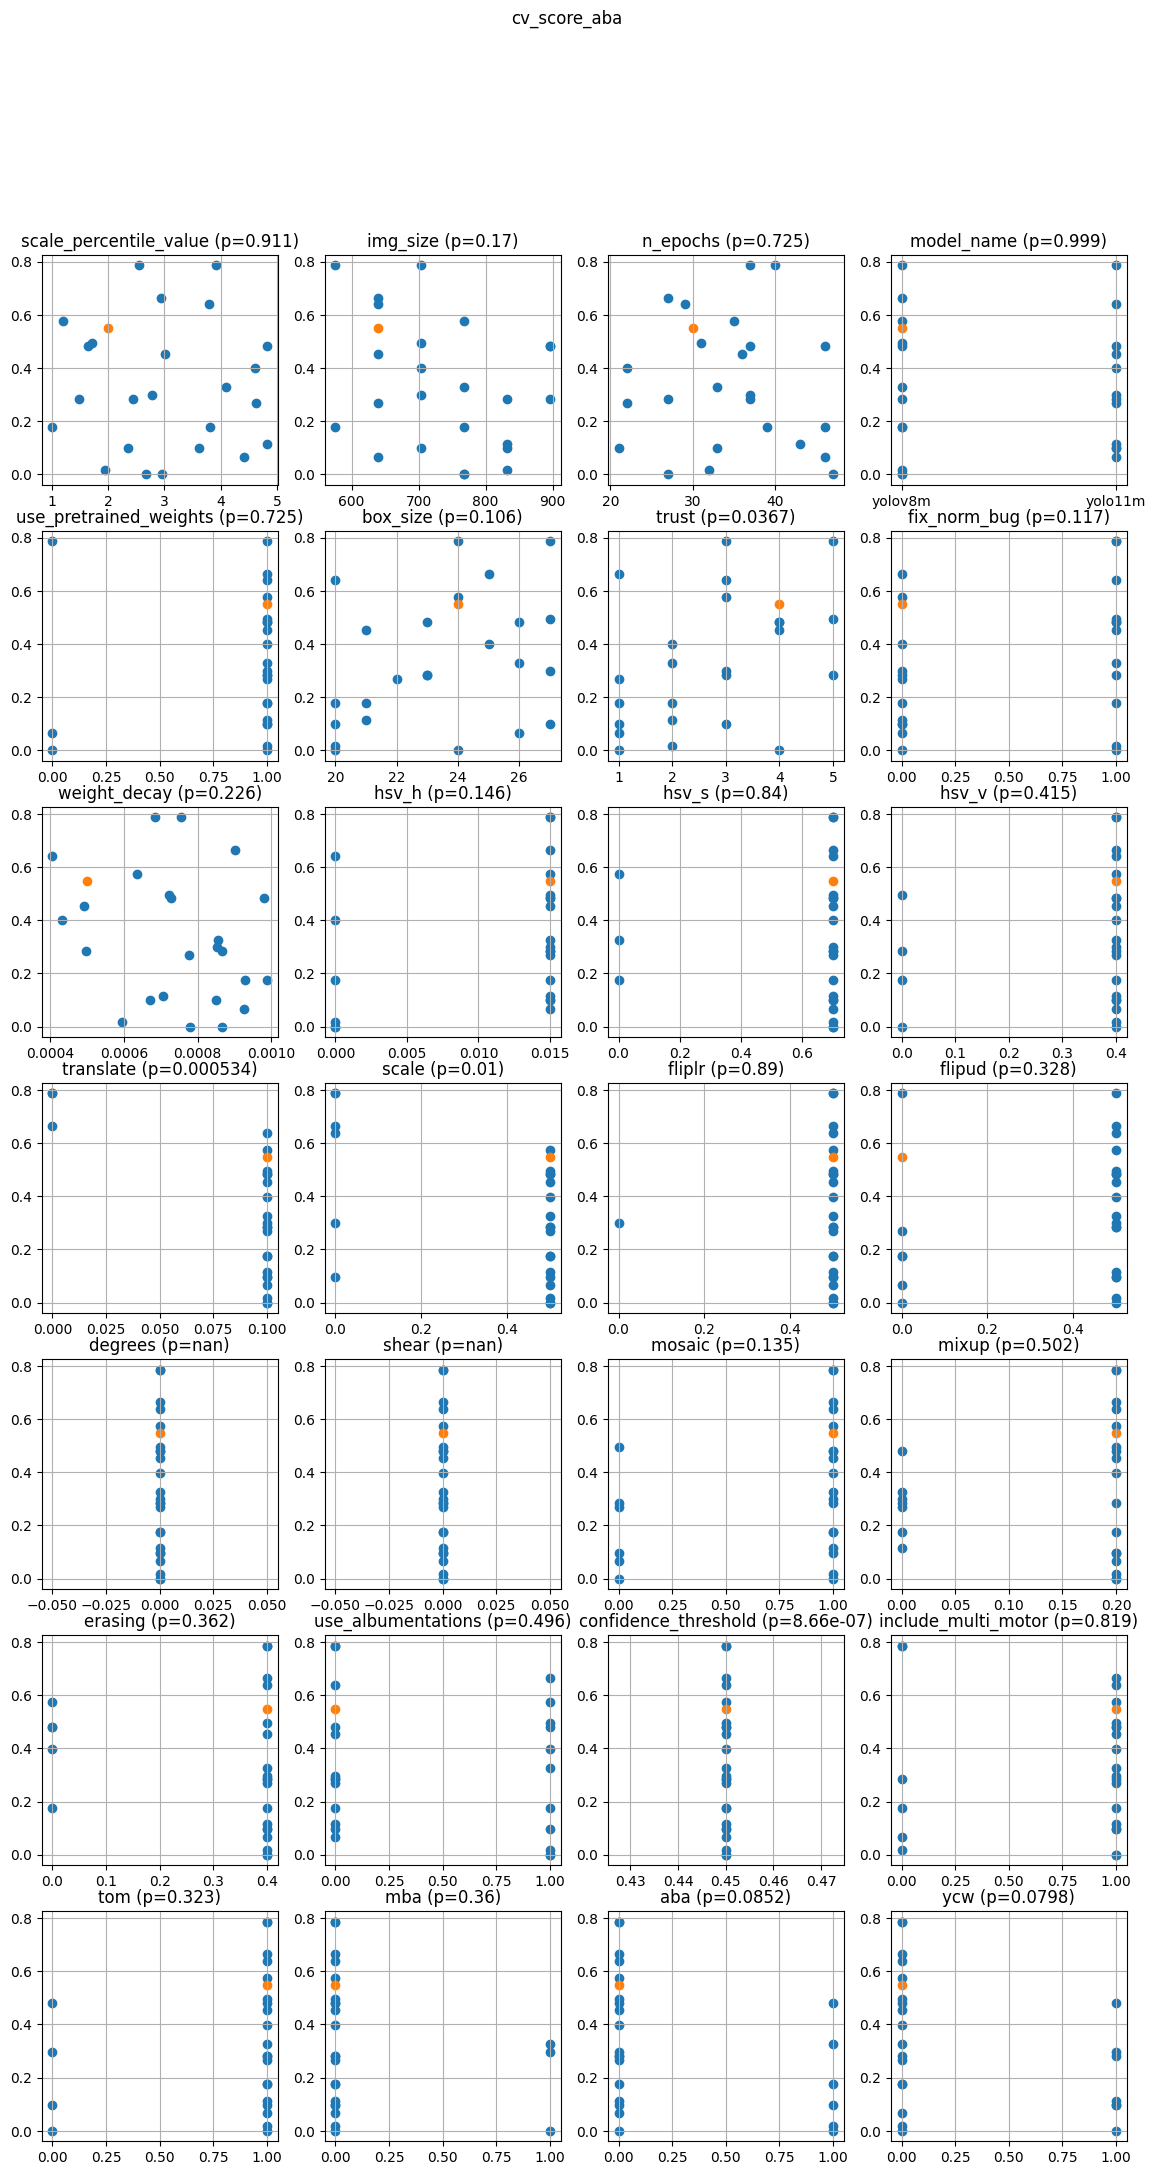

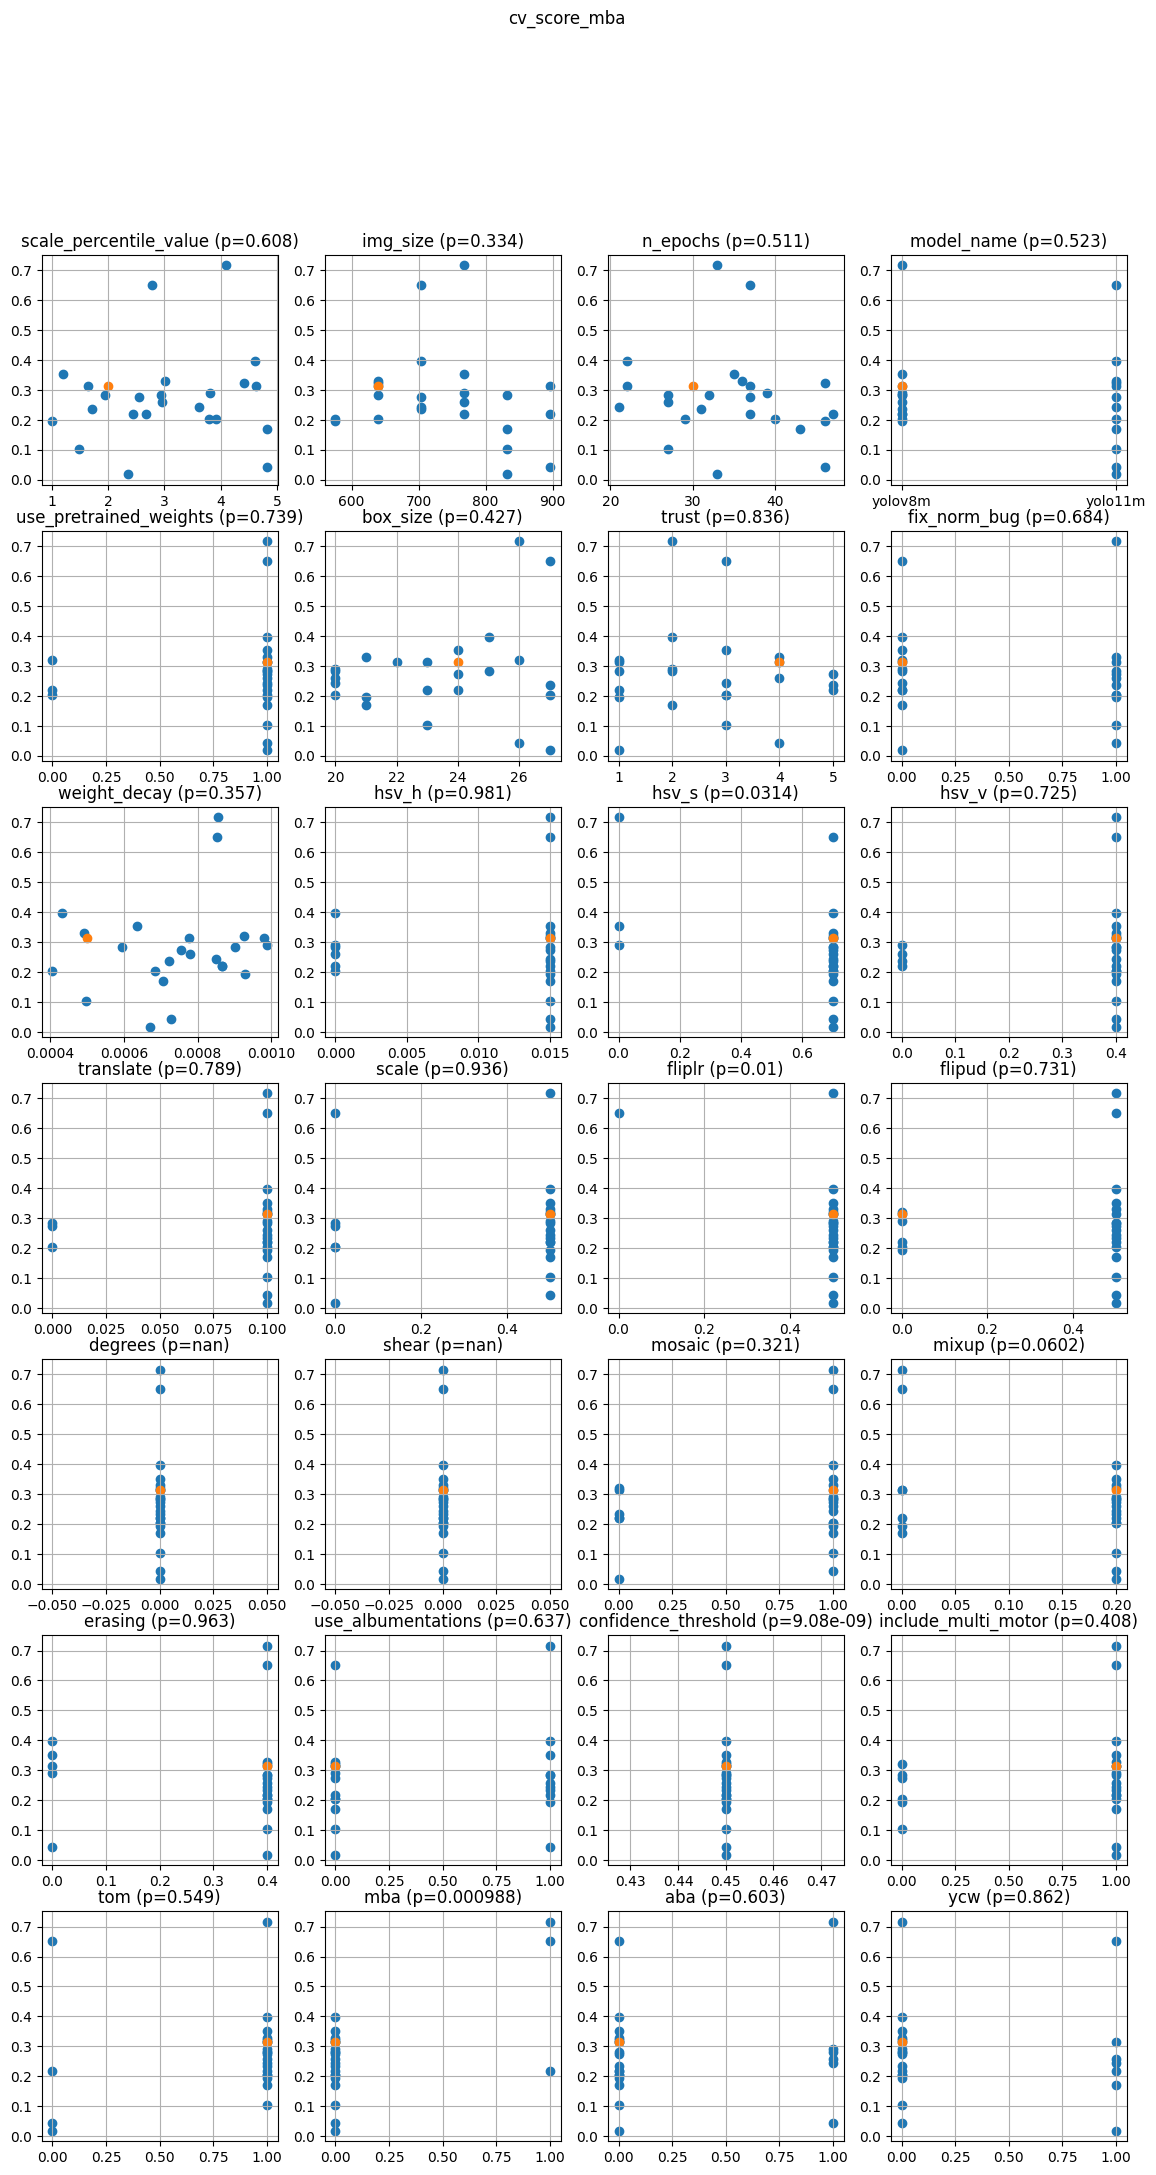

In [12]:
to_plot = p.columns.to_list()[2:-9]
main = np.logical_not(p['use_missing_value'])
for x_val in ['cv_score', 'cv_score_tom', 'cv_score_ycw', 'cv_score_aba', 'cv_score_mba']:
    plt.figure()
    plt.scatter(p[x_val][main], p['k_score'][main])
    plt.grid(True)
    plt.xlabel(x_val)
    plt.ylabel('Kaggle score')
ncols = 4
nrows = len(to_plot)//ncols
for y_val in p.columns[-6:][[0,5,1,2,3,4]].to_list():
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,14/ncols*nrows))
    plt.suptitle(y_val)
    for idx,d in enumerate(to_plot):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]
        plt.sca(ax)        
        plt.xlabel('')
        plt.ylabel('')
        plt.grid(True)
        plt.scatter(p[d][main], p[y_val][main])
        plt.scatter(p[d][np.logical_not(main)], p[y_val][np.logical_not(main)])
       
        # fit

        pp = copy.deepcopy(p)
        if not pd.api.types.is_numeric_dtype(pp[d]) or pd.api.types.is_bool_dtype(pp[d]):
            pp[d] = pp[d].astype('category').cat.codes
        X = pp[[d]][main]
        X['intercept'] = 1.
        y = p[y_val][main]
        to_keep = np.logical_not(np.isnan(y))
        X = X[to_keep]; y=y[to_keep];
        model = sm.OLS(y,X)
        results=model.fit()
        p_val = results.pvalues[d]
        plt.title(f'{d} (p={p_val:.3})')
        
        # if d == 'mask_sizes0':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][0] for m in model_list]
        # elif d == 'mask_sizes1':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][1] for m in model_list]
        # elif d == 'mask_sizes2':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][2] for m in model_list]
        # else:
        #     x_vals = [getattr(m, d)[model.particles_to_do[0]] for m in model_list]
        # if len(np.unique(x_vals))<8:
        #     #pass
        #     violin_plot(x_vals,score_vals)
        # else:
        #     plt.scatter(x_vals, score_vals)